In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

engine = create_engine('postgresql:///fundamentals')

df = pd.read_sql("SELECT marketcap, sector, calendardate  "
                 "FROM indicators_data "
                 "LEFT JOIN tickers_data "
                 "USING (ticker) "
                 "WHERE marketcap > 0 "
                 "AND sector IS NOT NULL "
                 "AND is_foreign = False "
                 "AND currency = 'USD'; ",
                 con=engine)


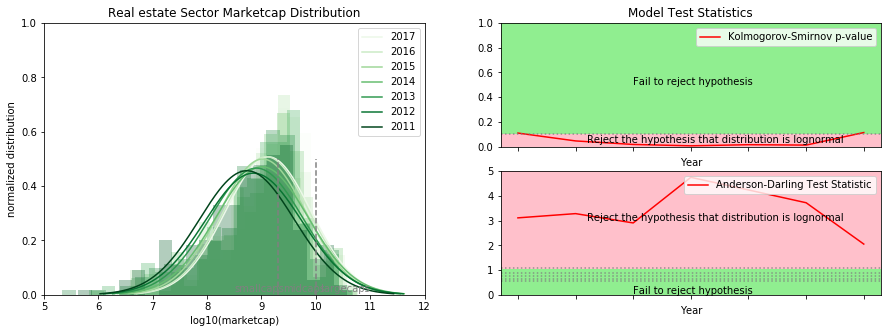

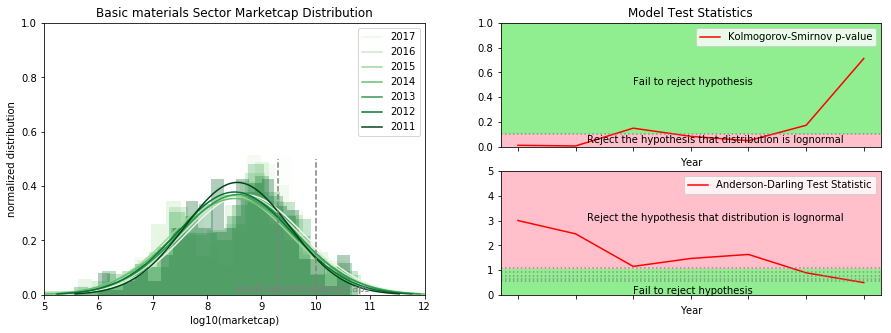

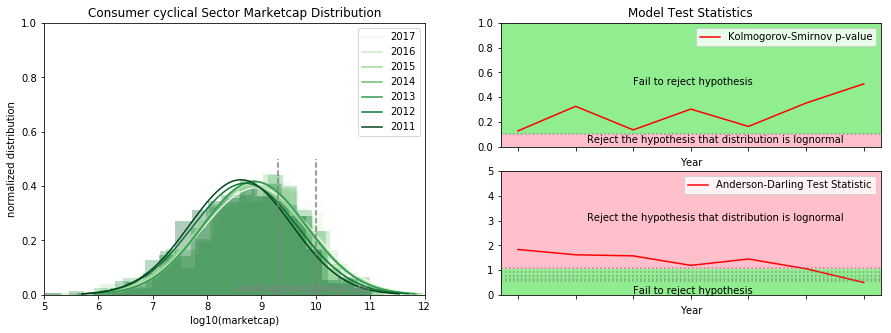

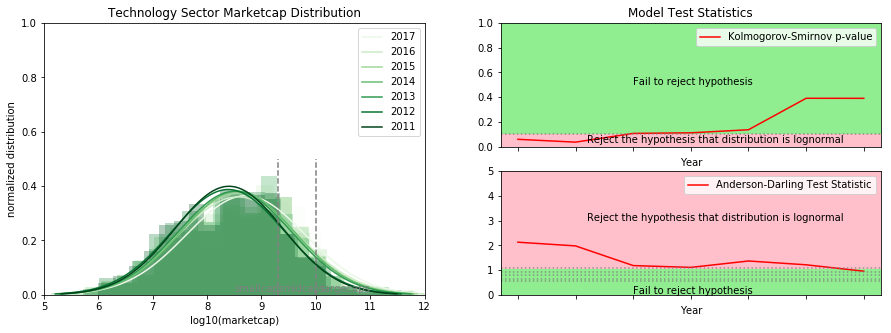

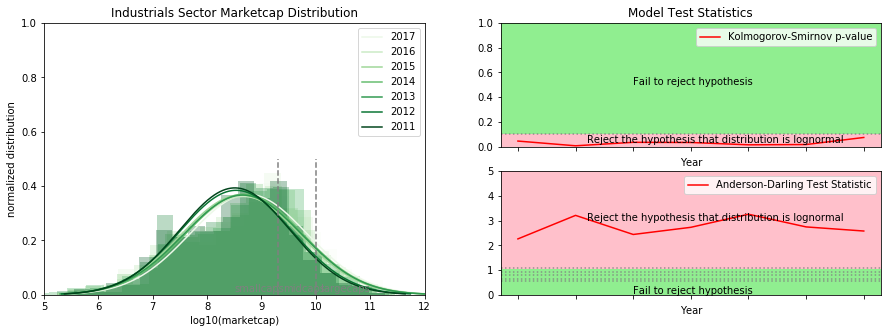

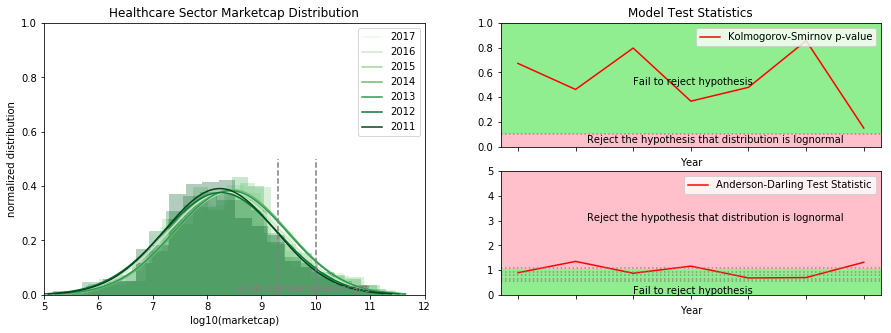

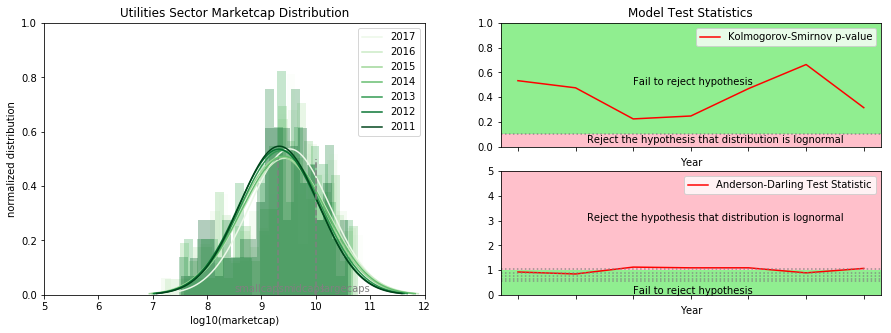

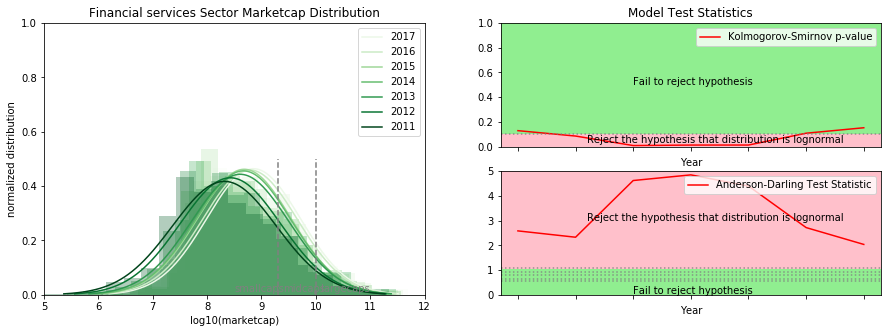

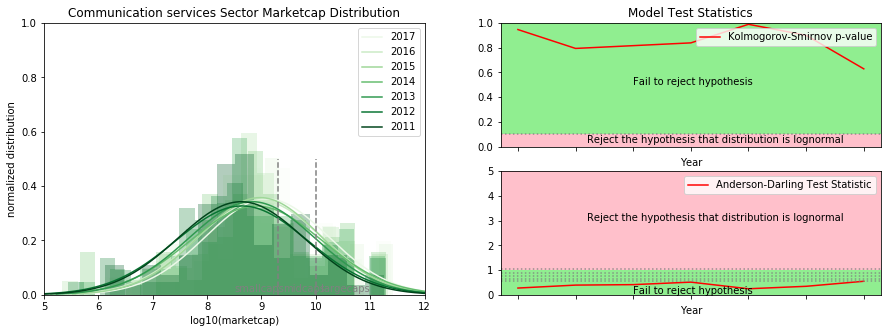

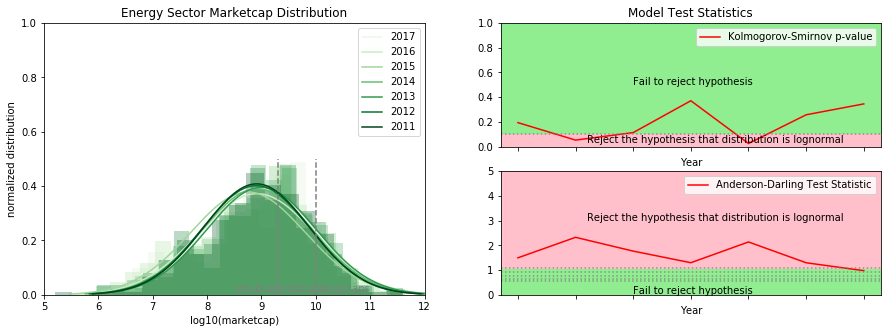

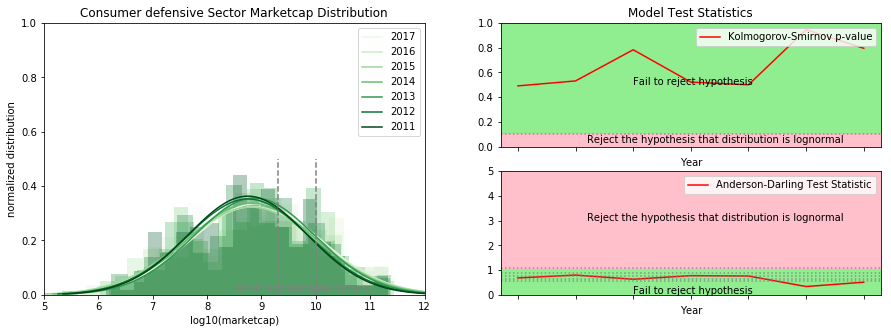

In [2]:
from scipy.stats import norm, pareto, kstest, anderson

def plotmodel(data, label, ax):
    
    # Build a histogram of the log10 of the data
    ax.hist(np.log10(data), bins=20, density=True, alpha=0.3, label=None)
    
    # Fit a normal model to the log10 of the data
    param = norm.fit(np.log10(data))
    model = norm(loc=param[0], scale=param[1])
    
    # Calculate Kolmogorov-Smirnov pvalue and Anderson-Darling stat
    ks_stat, pvalue = kstest(np.log10(data), model.cdf)
    ad_stat, critical_values, significance_level = anderson(np.log10(data), "norm")
    
    # Plot the lognorm model pdf
    x_plot = np.linspace(model.ppf(0.001), model.ppf(0.999), 5000)
    y_plot = model.pdf(x_plot)
    ax.plot(x_plot, y_plot, label=str(label))
            
    return pvalue, ad_stat, critical_values

for sector in df['sector'].unique():

    
    plt.figure(figsize=(15,5))
    
    ax1 = plt.subplot(1,2,1)
    ax1.set_prop_cycle('color', plt.cm.Greens(np.linspace(0,1,14)))
    ax2 = plt.subplot(2,2,2)
    ax3 = plt.subplot(2,2,4)
        
    stats = []

    for calendardate in df['calendardate'].unique():
        
        data = df[(df.sector == sector) & (df.calendardate == calendardate)].marketcap
        
        year = str(calendardate)[:4]
        
        pvalue, ad_stat, critical_values = plotmodel(data, year, ax1)
        
        stats.append([year, pvalue, ad_stat])
                
    ax1.set_title(sector.capitalize() + " Sector Marketcap Distribution")
    ax1.set_xlim(5,12)
    ax1.set_ylim(0,1)
    ax1.set_xlabel('log10(marketcap)')
    ax1.set_ylabel('normalized distribution')
    ax1.text(8.5, 0.01, 'smallcaps', color='grey')
    ax1.text(9.4, 0.01, 'midcaps', color='grey')
    ax1.text(10.1, 0.01, 'largecaps', color='grey')    
    ax1.axvline(np.log10(2e9), 0, 0.5, color='grey', linestyle='dashed')
    ax1.axvline(np.log10(10e9), 0, 0.5, color='grey', linestyle='dashed')    
    ax1.legend(loc='upper right')
    
    stats_df = pd.DataFrame(stats, columns=['Year',
                                            'Kolmogorov-Smirnov p-value',
                                            'Anderson-Darling Test Statistic']).set_index('Year')
    
    stats_df['Kolmogorov-Smirnov p-value'].plot(ax=ax2, ylim=(0,1), color='red', legend=True)
    stats_df['Anderson-Darling Test Statistic'].plot(ax=ax3, ylim=(0,5), color='red', legend=True)
    
    ax2.set_title("Model Test Statistics")
    ax2.set_facecolor('lightgreen')
    ax2.axhline(0.1, color='grey', alpha=0.8, linestyle='dotted')
    ax2.axhspan(0, 0.1, color='pink')
    ax2.text(1.2,0.03,"Reject the hypothesis that distribution is lognormal")
    ax2.text(2,0.5,"Fail to reject hypothesis")
    ax2.legend(loc='upper right')
    
    for val in critical_values:
        ax3.axhline(val, color='grey', alpha=0.8, linestyle='dotted')
    ax3.set_facecolor('lightgreen')
    ax3.axhspan(critical_values[-1], 5, color='pink')
    ax3.text(1.2,3,"Reject the hypothesis that distribution is lognormal")
    ax3.text(2,0.03,"Fail to reject hypothesis")
    ax3.legend(loc='upper right')


    
    plt.show()